<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/TPOT/blood_transfusion/keras_tuner_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q keras-tuner
%pip show keras-tuner scikit-learn

     |████████████████████████████████| 61kB 3.4MB/s 
Name: keras-tuner
Version: 1.0.1
Summary: Hypertuner for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The Keras Tuner authors
Author-email: kerastuner@google.com
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: tabulate, future, tqdm, scipy, requests, colorama, scikit-learn, terminaltables, numpy
Required-by: 
---
Name: scikit-learn
Version: 0.22.2.post1
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.6/dist-packages
Requires: joblib, numpy, scipy
Required-by: yellowbrick, umap-learn, textgenrnn, sklearn, sklearn-pandas, mlxtend, lucid, lightgbm, librosa, keras-tuner, imbalanced-learn, fancyimpute


[輸血データセット:https://www.openml.org/d/1464](https://www.openml.org/d/1464)

In [2]:
import datetime, IPython, os 

import numpy as np

from kerastuner import HyperModel, Hyperband
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report 

from tensorflow.keras import Sequential, layers, callbacks, optimizers
from tensorflow.keras.utils import to_categorical, plot_model

# データ読み込み

In [3]:
%%time
DATA_ID = '1464' #@param{type:'string'}

# データセットをフェッチ
X, y = fetch_openml(data_id=DATA_ID, return_X_y=True, as_frame=True)

def processing_y(y):
    '''ラベルyの加工'''
    def _convert_dtype(y, type='int64'):
        '''dtype: category(文字列型)をint64に変更'''
        return y.astype('int64')
    
    def _indicator_start_0(y):
        '''インディケータ開始の数を0にする'''
        return y - y[np.argmin(y)]

    def _encode_one_hot(y, dtype=('int64')):
        '''one-hotエンコーディング'''
        return to_categorical(y, dtype='int64')

    y = _convert_dtype(y)
    y = _indicator_start_0(y)
    y = _encode_one_hot(y)
    return y


y = processing_y(y)
display(X)
display(y)


SEED = 7 #@param{type:'number'}
SPLIT = 0.2 #@param{type:'number'}

train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size=SPLIT,
                                                    random_state=SEED,
                                                    shuffle=True)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=SPLIT,
                                                  random_state=SEED,
                                                  shuffle=True)

display('train shape:{}'.format(train_X.shape))
display('val shape:{}'.format(val_X.shape))
display('test shape:{}'.format(test_X.shape))

,V1,V2,V3,V4
0,2.0,50.0,12500.0,98.0
1,0.0,13.0,3250.0,28.0
2,1.0,16.0,4000.0,35.0
3,2.0,20.0,5000.0,45.0
4,1.0,24.0,6000.0,77.0
...,...,...,...,...
743,23.0,2.0,500.0,38.0
744,21.0,2.0,500.0,52.0
745,23.0,3.0,750.0,62.0
746,39.0,1.0,250.0,39.0


array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

'train shape:(478, 4)'

'val shape:(120, 4)'

'test shape:(150, 4)'

CPU times: user 70.8 ms, sys: 11.2 ms, total: 82 ms
Wall time: 422 ms


# モデル構築

In [4]:
class BloodHyperModel(HyperModel):

      def __init__(self, input_shape, num_classes, train_X_np):
          self.input_shape = input_shape
          self.num_classes = num_classes
          self.norm_layer = self._setupNormalizationLayer(X=train_X_np)
      

      def _setupNormalizationLayer(self, X):
          '''正規化の前処理レイヤーを初期化'''
          norm_layer = layers.experimental.preprocessing.Normalization()
          norm_layer.adapt(X)
          return norm_layer


      def build(self, hp):
          '''モデル構造と探索空間の定義'''
          model = Sequential()
          model.add(layers.Input(shape=self.input_shape))

          hp_processing_layer = hp.Boolean('is_processing_layer', default=False)
          if hp_processing_layer:
              model.add(self.norm_layer)
            
          for i in range(hp.Int('num_layers', min_value=2, max_value=10, step=1)):
              units = hp.Int('units_'+str(i), min_value=16, max_value=128, step=16)
              model.add(layers.Dense(units=units, activation='relu'))
              model.add(layers.Dropout(rate=0.3))

          model.add(layers.Dense(self.num_classes, activation='softmax'))

          model.compile(
              optimizer=optimizers.Adam(
                  hp.Choice('learning_rate', [1e-1, 1e-3, 1e-4])),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'categorical_crossentropy'])
          
          return model

In [5]:
input_shape = (train_X.shape[1], )
NUM_CLASSES = 2

# Hyperbandアルゴリズムの試行回数(default:1)
HYPERBAND_ITERATIONS = 2 #@param{type:'number'}
# Hyperbandアルゴリズムで使用する削減率(default:3)
FACTOR = 3 #@param{type:'number'}
# 1つあたりのモデルのEpoch数
MAX_EPOCHS = 20 #@param{type:'number'}
SEED = 7


hyper_model = BloodHyperModel(input_shape=input_shape,
                              num_classes=NUM_CLASSES,
                              train_X_np=train_X.values)
display(hyper_model)

tuner = Hyperband(hypermodel=hyper_model,
                  objective='val_accuracy',
                  hyperband_iterations=HYPERBAND_ITERATIONS,
                  factor=FACTOR,
                  max_epochs=MAX_EPOCHS,
                  seed=SEED
                  )
display(tuner)

# 早期停止コールバックの定義
es = callbacks.EarlyStopping(monitor='val_loss',
                             patience=5)

class ClearTrainingOutput(callbacks.Callback):
    '''Ipythonログをクリアするコールバックのクラス定義'''
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [6]:
%%time
tuner.search(train_X.values, train_y,
             validation_data=(val_X.values, val_y),
             callbacks=[es, ClearTrainingOutput()],
             verbose=1)

INFO:tensorflow:Oracle triggered exit
CPU times: user 2min 2s, sys: 7.97 s, total: 2min 10s
Wall time: 2min 10s


# ベストなモデルの可視化

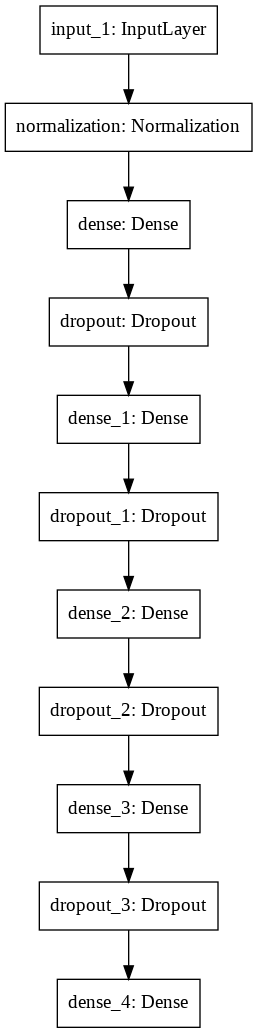

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 48)                240       
_________________________________________________________________
dropout (Dropout)            (None, 48)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               5488      
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 96)                10848     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96)                0

None

{'is_processing_layer': True,
 'learning_rate': 0.001,
 'num_layers': 4,
 'tuner/bracket': 1,
 'tuner/epochs': 7,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_0': 48,
 'units_1': 112,
 'units_2': 96,
 'units_3': 48,
 'units_4': 128,
 'units_5': 48,
 'units_6': 80,
 'units_7': 16,
 'units_8': 96,
 'units_9': 64}

In [7]:
def display_best_model(tuner):
    '''ベストなモデルの構造を表示'''
    best_model = tuner.get_best_models()[0]
    display(plot_model(best_model))
    display(best_model.summary())


def display_best_hp(tuner):
    '''ベストなハイパーパラメータを表示'''
    best_hp = tuner.get_best_hyperparameters()[0]
    display(best_hp.get_config()['values'])


display_best_model(tuner)
display_best_hp(tuner)

# モデルの評価

In [8]:
def take_best_model(tuner):
    '''ベストなモデルを取り出し'''
    best_model = tuner.get_best_models()[0]
    return best_model


model = take_best_model(tuner)   

## Kerasの組み込み評価関数

In [9]:
score = model.evaluate(x=test_X.values, y=test_y, batch_size=256)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

1/1 [==============================] - 0s 11ms/step - loss: 0.4767 - accuracy: 0.7467 - categorical_crossentropy: 0.4767


'loss : 0.4766902029514313, accuracy : 0.746666669845581'

## sklearnの評価関数

In [10]:
%%time
def predict_classes(model, X):
    '''クラスラベルの予測を取得'''
    return np.argmax(model.predict(X), axis=-1)


# 予測結果の取得
train_y_pred = predict_classes(model, train_X.values)
val_y_pred = predict_classes(model, val_X.values)
test_y_pred = predict_classes(model, test_X.values)


def encode_class_label(one_hot_vector):
    '''one-hotベクトルをクラスラベルに変換'''
    return np.argmax(one_hot_vector, axis=1)


train_report = classification_report(y_true=encode_class_label(train_y), y_pred=train_y_pred)
val_report = classification_report(y_true=encode_class_label(val_y), y_pred=val_y_pred)
test_report = classification_report(y_true=encode_class_label(test_y), y_pred=test_y_pred)

print(train_report)
print('----- -----')
print(val_report)
print('----- -----')
print(test_report)

              precision    recall  f1-score   support

           0       0.84      0.94      0.89       366
           1       0.68      0.41      0.51       112

    accuracy                           0.82       478
   macro avg       0.76      0.68      0.70       478
weighted avg       0.80      0.82      0.80       478

----- -----
              precision    recall  f1-score   support

           0       0.83      0.96      0.89        92
           1       0.71      0.36      0.48        28

    accuracy                           0.82       120
   macro avg       0.77      0.66      0.68       120
weighted avg       0.80      0.82      0.79       120

----- -----
              precision    recall  f1-score   support

           0       0.78      0.91      0.84       112
           1       0.50      0.26      0.34        38

    accuracy                           0.75       150
   macro avg       0.64      0.59      0.59       150
weighted avg       0.71      0.75      0.72       